In [1]:
# Manejo de Datos
import pandas as pd
import geopandas as gpd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import nbformat

# Mapas
import osmnx as ox
from shapely.geometry import Point, LineString

In [2]:
# Importar Datos Iniciales
df_partida = pd.read_csv('PuntoPartida.csv', sep='\t')
df_llegada = pd.read_csv('PuntoLlegada.csv', sep='\t')
df_siniestros = pd.read_csv('Siniestros.csv', sep='\t')

In [3]:
# Limpieza de Datos
df_llegada.loc[df_llegada['IDRuta'] == 'b2', 'Longitud'] = -100.318156048963 # Llevaba una coma al final
df_llegada['Longitud'] = df_llegada['Longitud'].astype(float)

In [4]:
df_rutas = pd.merge(df_partida, df_llegada, on=['IDRuta', 'NombreRuta', 'ValorMercancia', 'IDConductor'], suffixes=('Partida', 'Llegada')).copy()
df_rutas

,IDRuta,NombreRuta,TipoUbicacionPartida,EmpresaPartida,HoraProgramadaSalida,LongitudPartida,LatitudPartida,ValorMercancia,IDConductor,TipoUbicacionLlegada,EmpresaLlegada,HoraSalida,LongitudLlegada,LatitudLlegada
0,a1,Relleno de Inventario,Bodega,Empresa 1,10:00:00,-100.316540,25.696300,150000,1,Tienda,Empresa 1,10:03:00,-100.228542,25.550476
1,b2,Traslado de efectivo,Tienda,Empresa 1,9:00:00,-100.203823,25.663144,300000,1,Banco,Banco 1,8:58:00,-100.318156,25.685163
2,c3,Relleno de Inventario,Bodega,Empresa 3,14:00:00,-100.145293,25.788839,1500000,1,Tienda,Empresa 3,14:10:00,-100.242414,25.664271
3,d4,Relleno de Inventario,Bodega,Empresa 2,11:00:00,-100.367606,25.814914,200000,1,Tienda,Empresa 2,11:00:19,-100.381548,25.664200
4,e5,Traslado de efectivo,Tienda,Empresa 3,15:00:00,-100.421277,25.744508,123000,1,Banco,Banco 1,16:00:00,-100.318156,25.685163


In [5]:
# Obtener grafo de rutas con sus atributos de distancia y tiempo
# Nota: puede tomar un par de minutos
coords_promedio = (df_rutas['LatitudPartida'].mean(), df_rutas['LongitudPartida'].mean())

G = ox.graph_from_point(coords_promedio, dist=20000, network_type='drive') # Se obtienen nodos a 20 km de distancia
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

c:\Users\Gustavo\miniconda3\envs\DS\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


In [6]:
# Asignar nodos de partida y llegada a cada ruta
df_rutas.loc[:, 'NodoPartida'] = df_rutas.apply(lambda row: ox.distance.nearest_nodes(G, row['LongitudPartida'], row['LatitudPartida']), axis=1)
df_rutas.loc[:, 'NodoLlegada'] = df_rutas.apply(lambda row: ox.distance.nearest_nodes(G, row['LongitudLlegada'], row['LatitudLlegada']), axis=1)

In [7]:
# Calcular distancia y tiempo de cada ruta, y graficarlas
mapa_rutas = folium.Map(location=coords_promedio, zoom_start=12)

colores_rutas = ['red', 'blue', 'green', 'purple', 'orange']
coords_lat_lon = []

for idx, row in df_rutas.iterrows():
    ruta = ox.shortest_path(G, row['NodoPartida'], row['NodoLlegada'], weight='travel_time')
    df_rutas.loc[idx, 'DistanciaRutaKilometros'] = int(sum(ox.routing.route_to_gdf(G, ruta, weight="travel_time")["length"])) / 1000
    df_rutas.loc[idx, 'TiempoRutaMinutos'] = int(sum(ox.routing.route_to_gdf(G, ruta, weight="travel_time")["travel_time"])) / 60
    coords_ruta = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in ruta]
    coords_lat_lon.append((row['IDRuta'], coords_ruta))
    folium.PolyLine(coords_ruta, weight=5, color=colores_rutas[idx]).add_to(mapa_rutas)

In [8]:
# mapa_rutas.save('mapa_rutas.html')
mapa_rutas

In [9]:
# Calcular Hora Estimada de Llegada
df_rutas['HoraSalida'] = pd.to_datetime(df_rutas['HoraSalida'], format='%H:%M:%S').dt.time
df_rutas['HoraEstimadaLlegada'] = (pd.to_datetime(df_rutas['HoraSalida'], format='%H:%M:%S') + pd.to_timedelta(df_rutas['TiempoRutaMinutos'], unit='m')).dt.floor('s').dt.time

In [10]:
df_rutas

,IDRuta,NombreRuta,TipoUbicacionPartida,EmpresaPartida,HoraProgramadaSalida,LongitudPartida,LatitudPartida,ValorMercancia,IDConductor,TipoUbicacionLlegada,EmpresaLlegada,HoraSalida,LongitudLlegada,LatitudLlegada,NodoPartida,NodoLlegada,DistanciaRutaKilometros,TiempoRutaMinutos,HoraEstimadaLlegada
0,a1,Relleno de Inventario,Bodega,Empresa 1,10:00:00,-100.316540,25.696300,150000,1,Tienda,Empresa 1,10:03:00,-100.228542,25.550476,7483136608,7029667490,20.517,19.466667,10:22:28
1,b2,Traslado de efectivo,Tienda,Empresa 1,9:00:00,-100.203823,25.663144,300000,1,Banco,Banco 1,08:58:00,-100.318156,25.685163,1736480453,1678662772,12.909,13.750000,09:11:45
2,c3,Relleno de Inventario,Bodega,Empresa 3,14:00:00,-100.145293,25.788839,1500000,1,Tienda,Empresa 3,14:10:00,-100.242414,25.664271,1762529953,1682430162,22.584,21.516667,14:31:31
3,d4,Relleno de Inventario,Bodega,Empresa 2,11:00:00,-100.367606,25.814914,200000,1,Tienda,Empresa 2,11:00:19,-100.381548,25.664200,8741156167,5203314935,23.733,25.200000,11:25:31
4,e5,Traslado de efectivo,Tienda,Empresa 3,15:00:00,-100.421277,25.744508,123000,1,Banco,Banco 1,16:00:00,-100.318156,25.685163,7439895423,1678662772,14.047,14.000000,16:14:00


In [11]:
### Parte 1, Inciso a)
# Calcula la driving distance (distancia en automóvil) y un estimado del tiempo de llegada de cada ruta
df_rutas[['IDRuta', 'DistanciaRutaKilometros', 'TiempoRutaMinutos', 'HoraSalida', 'HoraEstimadaLlegada']]

,IDRuta,DistanciaRutaKilometros,TiempoRutaMinutos,HoraSalida,HoraEstimadaLlegada
0,a1,20.517,19.466667,10:03:00,10:22:28
1,b2,12.909,13.750000,08:58:00,09:11:45
2,c3,22.584,21.516667,14:10:00,14:31:31
3,d4,23.733,25.200000,11:00:19,11:25:31
4,e5,14.047,14.000000,16:00:00,16:14:00


In [12]:
df_siniestros.sample(5)

,FolioSiniestro,Evento,Subtipo,UnidadOperativa,IDTienda,IDVehiculo,ValorPerdido,Latitud,Longitud
39,10001418,Robo,Sin violencia,Vehiculo,NaN,4.0,20451,25.677750,-100.249038
21,10001229,Robo,Con violencia,Tienda,2.0,NaN,66669,25.705076,-100.224514
47,10001144,Vandalismo,NaN,Vehiculo,NaN,1.0,56972,25.669278,-100.235860
32,10001339,Vandalismo,NaN,Vehiculo,NaN,3.0,18176,25.683101,-100.282867
22,1000137,Robo,Con violencia,Tienda,3.0,NaN,146161,25.702765,-100.361956


In [13]:
df_siniestros.isnull().sum()

FolioSiniestro      0
Evento              0
Subtipo            21
UnidadOperativa     0
IDTienda           14
IDVehiculo         41
ValorPerdido        0
Latitud             0
Longitud            0
dtype: int64

In [14]:
# Clasificar siniestros como riesgo bajo, medio o alto

def clasificar_evento(evento, subtipo):
    if evento == 'Robo' or evento == 'Vandalismo':
        if subtipo == 'Con violencia':
            return 'Medio'
        else:
            return 'Bajo'
    elif evento == 'Extorsión':
        return 'Medio'
    else:
        return 'Alto'
    
df_siniestros['NivelRiesgo'] = df_siniestros.apply(lambda row: clasificar_evento(row['Evento'], row['Subtipo']), axis=1)

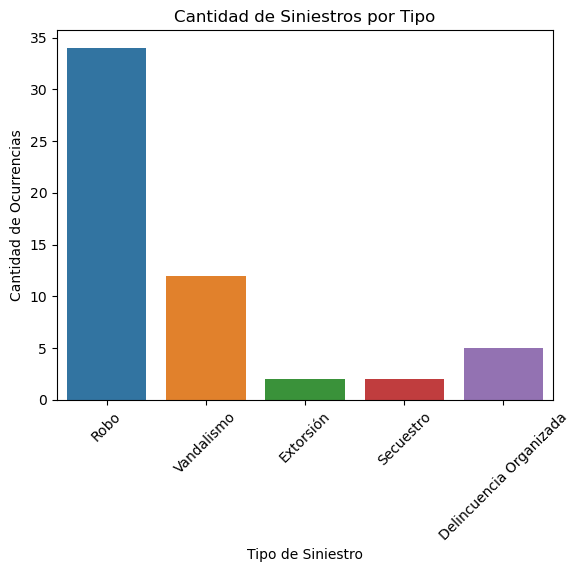

In [15]:
sns.countplot(data=df_siniestros, x='Evento', hue='Evento')
plt.ylabel('Cantidad de Ocurrencias')
plt.xlabel('Tipo de Siniestro')
plt.xticks(rotation=45)
plt.title('Cantidad de Siniestros por Tipo')
plt.show()

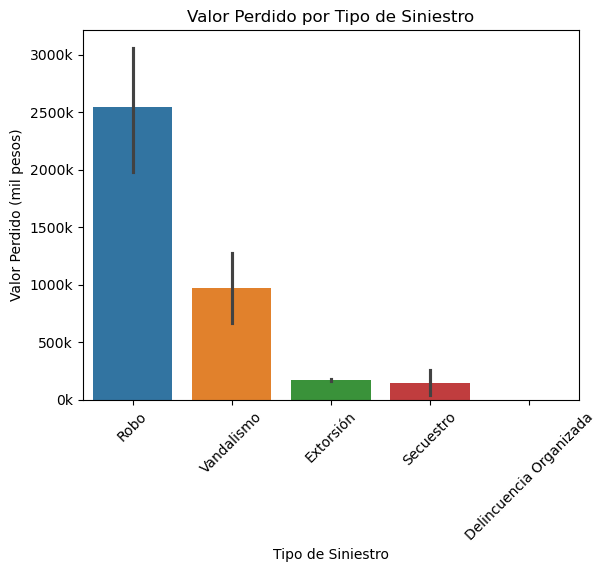

In [16]:
sns.barplot(data=df_siniestros, x='Evento', y='ValorPerdido', estimator=sum, hue='Evento')
plt.ylabel('Valor Perdido (mil pesos)')
plt.xlabel('Tipo de Siniestro')
plt.xticks(rotation=45)
plt.title('Valor Perdido por Tipo de Siniestro')

plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x / 1000)}k'))
plt.show()

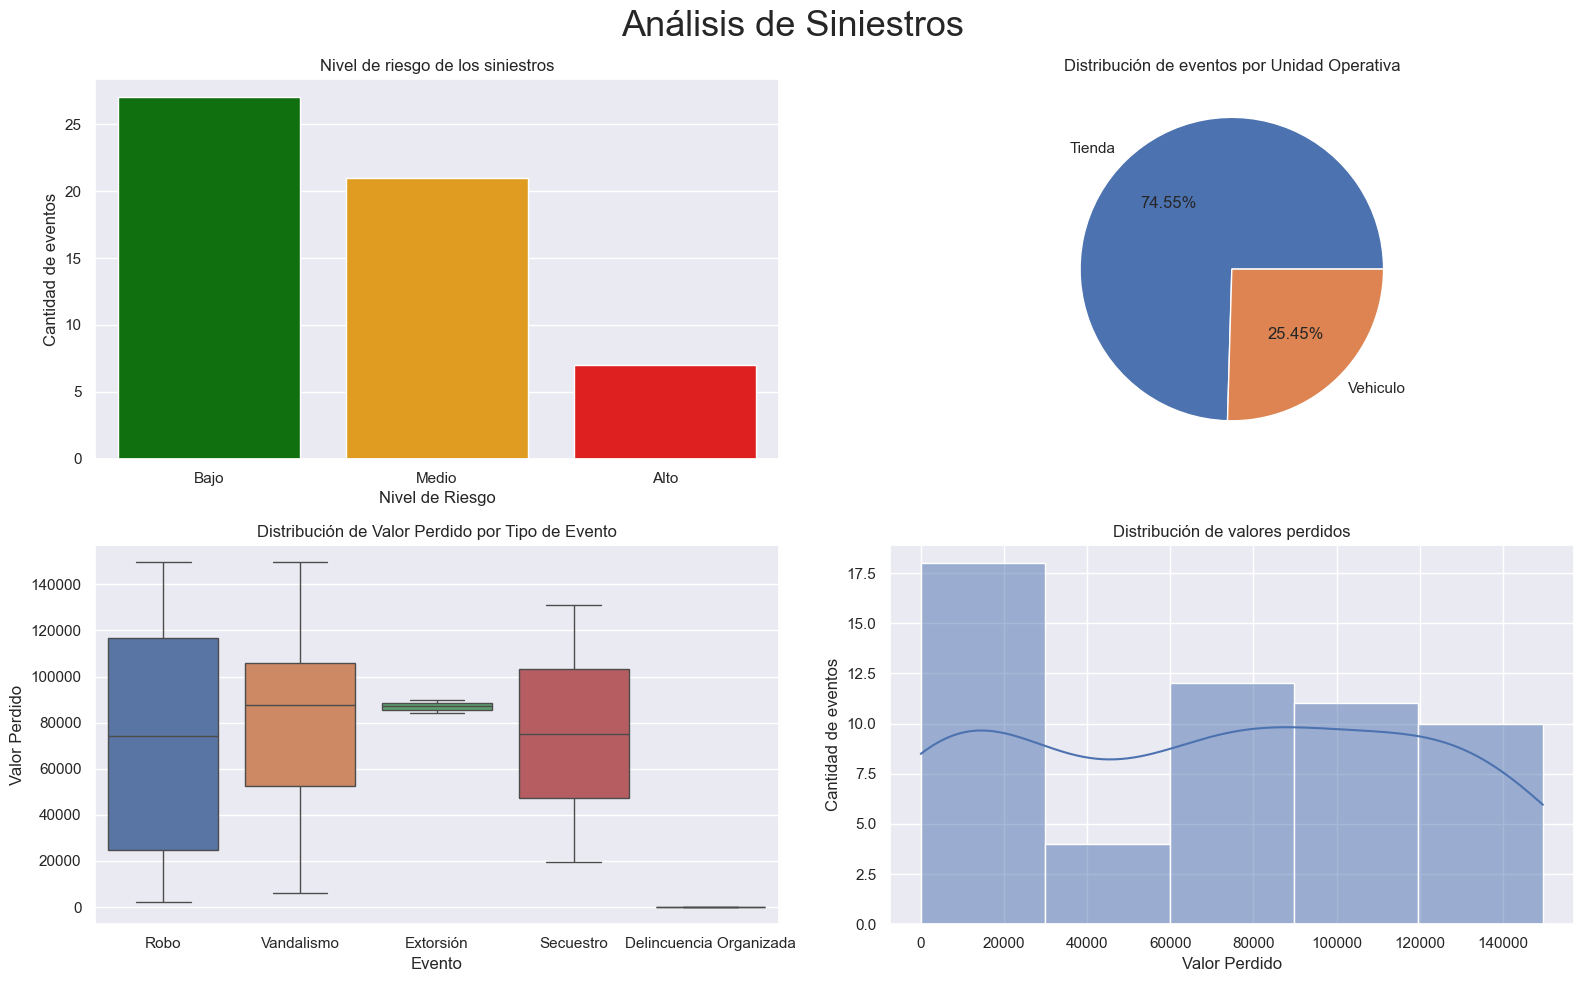

In [17]:
### Parte 1, Inciso b)
# Realiza un gráfico que muestre una descripción de la tabla encontrada en la hoja de Siniestros

# Creacion de Dashboard de Análisis de Siniestros

sns.set_theme(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

colores_riesgos = {'Alto': 'red', 'Medio': 'orange', 'Bajo': 'green'}
sns.countplot(ax=axs[0, 0], x='NivelRiesgo', data=df_siniestros, order=df_siniestros['NivelRiesgo'].value_counts().index, hue='NivelRiesgo', palette=colores_riesgos)
axs[0, 0].set_title('Nivel de riesgo de los siniestros')
axs[0, 0].set_ylabel('Cantidad de eventos') 
axs[0, 0].set_xlabel('Nivel de Riesgo')

df_siniestros['UnidadOperativa'].value_counts().plot.pie(ax=axs[0, 1], autopct='%1.2f%%')
axs[0, 1].set_title('Distribución de eventos por Unidad Operativa')
axs[0, 1].set_ylabel('')
axs[0, 1].set_xlabel('')

sns.boxplot(ax=axs[1, 0], x='Evento', y='ValorPerdido', data=df_siniestros, hue='Evento')
axs[1, 0].set_title('Distribución de Valor Perdido por Tipo de Evento')
axs[1, 0].set_xlabel('Evento')
axs[1, 0].set_ylabel('Valor Perdido')

sns.histplot(ax=axs[1, 1], data=df_siniestros['ValorPerdido'], bins=5, kde=True)
axs[1, 1].set_title('Distribución de valores perdidos')
axs[1, 1].set_xlabel('Valor Perdido')
axs[1, 1].set_ylabel('Cantidad de eventos')

fig.suptitle('Análisis de Siniestros', fontsize=26)
plt.tight_layout()
plt.show()


In [18]:
df_siniestros.head()

,FolioSiniestro,Evento,Subtipo,UnidadOperativa,IDTienda,IDVehiculo,ValorPerdido,Latitud,Longitud,NivelRiesgo
0,10001415,Robo,Con violencia,Tienda,4.0,NaN,84723,25.808908,-100.379278,Medio
1,10001213,Robo,Con violencia,Vehiculo,NaN,2.0,117041,25.799021,-100.386182,Medio
2,10001224,Robo,Sin violencia,Vehiculo,NaN,2.0,116400,25.797738,-100.381691,Bajo
3,10001327,Robo,Sin violencia,Vehiculo,NaN,3.0,117888,25.786821,-100.379681,Bajo
4,10001316,Robo,Con violencia,Tienda,3.0,NaN,73533,25.777179,-100.180762,Medio


In [19]:
# Crear geodataframe de siniestros
geometry_siniestros = [Point(xy) for xy in zip(df_siniestros['Longitud'], df_siniestros['Latitud'])]
gdf_siniestros = gpd.GeoDataFrame(df_siniestros, geometry=geometry_siniestros)
gdf_siniestros.crs = 'EPSG:4326' # Formato WGS84, estandar en GPS
gdf_siniestros = gdf_siniestros.to_crs(epsg=3857) # Se cambia a formato EPSG 3857 para visualización en folium

In [20]:
# Crear geodataframe de rutas
data_rutas = []
for ruta_id, coords in coords_lat_lon:
    coords_lon_lat = [(lon, lat) for lat, lon in coords]
    line = LineString(coords_lon_lat)
    data_rutas.append({'IDRuta': ruta_id, 'geometry': line})

gdf_rutas = gpd.GeoDataFrame(data_rutas)

gdf_rutas.crs = 'EPSG:4326' # Formato WGS84, estandar en GPS
gdf_rutas = gdf_rutas.to_crs(epsg=3857) # Se cambia a formato EPSG 3857 para visualización en folium

gdf_rutas['geometry'] = gdf_rutas.geometry.buffer(1300) # Se crea un buffer de 1300 metros alrededor de la ruta

In [21]:
# Asignar siniestros a rutas
gdf_siniestros_rutas = gpd.sjoin(gdf_siniestros, gdf_rutas, how='left', predicate='intersects') # Se hace un left join porque un siniestro puede pertenecer a varias rutas
gdf_siniestros_rutas = gdf_siniestros_rutas.dropna(subset=['IDRuta']).copy()
gdf_siniestros_rutas['Ponderacion'] = gdf_siniestros_rutas['NivelRiesgo'].map({'Bajo': 2, 'Medio': 5, 'Alto': 10}) # Ajusar ponderación según nivel de riesgo

In [22]:
# Obtener métricas de riesgo por ruta
gdf_riesgos_rutas = gdf_siniestros_rutas.groupby('IDRuta').agg({
    'FolioSiniestro': 'count',
    'ValorPerdido': 'sum',
    'Ponderacion': 'sum'
}).rename(columns={
    'FolioSiniestro': 'NumSiniestros',
    'ValorPerdido': 'TotalValorPerdido',
    'Ponderacion': 'TotalPonderacion'
}).reset_index()

In [23]:
### IMPORTANTE ###
# Cálculo de índice de riesgo

# Se define IndiceRiesgo como la suma de la ponderación de los siniestros y el valor perdido en cientos de miles de pesos
# Estos son valores arbitrarios y pueden ser ajustados según la importancia relativa de cada métrica
gdf_riesgos_rutas['IndiceRiesgo'] = gdf_riesgos_rutas['TotalPonderacion'] + (gdf_riesgos_rutas['TotalValorPerdido'] / 100000) 

# Se calculan umbrales del indice de riesgo para poder clasificar las rutas en niveles de riesgo. Los valores son arbitrarios y pueden ser ajustados
umbral_bajo = gdf_riesgos_rutas['IndiceRiesgo'].quantile(0.20) 
umbral_medio = gdf_riesgos_rutas['IndiceRiesgo'].quantile(0.60)

def asignar_nivel_riesgo(indice_riesgo):
    if indice_riesgo <= umbral_bajo:
        return 'Bajo'
    elif indice_riesgo <= umbral_medio:
        return 'Medio'
    else:
        return 'Alto'
    
gdf_riesgos_rutas['NivelRiesgo'] = gdf_riesgos_rutas['IndiceRiesgo'].apply(asignar_nivel_riesgo)

In [24]:
# Se crea un nuevo GeoDataFrame con las geometría de las rutas y sus métricas de riesgo
gdf_rutas = gdf_rutas.merge(gdf_riesgos_rutas, on='IDRuta', how='left')
gdf_rutas['Ranking'] = gdf_rutas['IndiceRiesgo'].rank(method='min', ascending=False)

In [25]:
gdf_rutas

,IDRuta,geometry,NumSiniestros,TotalValorPerdido,TotalPonderacion,IndiceRiesgo,NivelRiesgo,Ranking
0,a1,"POLYGON ((-11168906.870 2958100.945, -11168895...",12,155986,79,80.55986,Alto,2.0
1,b2,"POLYGON ((-11166968.063 2958911.573, -11166976...",15,344580,69,72.44580,Medio,3.0
2,c3,"POLYGON ((-11159928.422 2958245.987, -11159917...",14,854135,43,51.54135,Bajo,5.0
3,d4,"POLYGON ((-11176271.861 2972120.522, -11176282...",15,1783572,53,70.83572,Medio,4.0
4,e5,"POLYGON ((-11177881.945 2968412.214, -11177781...",16,1638424,77,93.38424,Alto,1.0


In [26]:
# Se genera un nuevo mapa
centro_mapa = [gdf_siniestros['Latitud'].mean(), gdf_siniestros['Longitud'].mean()]
mapa_rutas_riesgo = folium.Map(location=centro_mapa, zoom_start=12)

In [27]:
colores_rutas_hex = ['#FF0000', '#0000FF', '#00FF00', '#800080', '#FFA500']  # Rojo, Azul, Verde, Morado, Naranja
colores_rutas = {row['IDRuta']: colores_rutas_hex[i % len(colores_rutas_hex)] for i, (_, row) in enumerate(gdf_rutas.iterrows())}

In [28]:
# Dibujar las rutas con sus buffers
folium.GeoJson(
    gdf_rutas,
    name='Buffer de Ruta',
    style_function=lambda feature: {
        'color': colores_rutas[feature['properties']['IDRuta']],
        'weight': 1,
        'fillOpacity': 0.2
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=['IDRuta', 'NivelRiesgo', 'IndiceRiesgo', 'Ranking', 'NumSiniestros', 'TotalValorPerdido'],
        aliases=['Ruta', 'Nivel de Riesgo', 'Índice de Riesgo', 'Ranking', 'Número de Siniestros', 'Valor Total Perdido'],
        localize=True
    )
).add_to(mapa_rutas_riesgo)

In [29]:
# Agregar circulos que representan los siniestros y su nivel de riesgo
for _, row in gdf_siniestros.iterrows():
    if row['NivelRiesgo'] == 'Alto':
        color = 'red'
        radius = 8
    elif row['NivelRiesgo'] == 'Medio':
        color = 'orange'
        radius = 6
    else:
        color = 'green'
        radius = 4

    folium.CircleMarker(
        location=(row['Latitud'], row['Longitud']),
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        tooltip=(
            f"Siniestro: {row['FolioSiniestro']}<br>"
            f"Valor Perdido: ${row['ValorPerdido']}<br>"
            f"Nivel de Riesgo: {row['NivelRiesgo']}"
        )
    ).add_to(mapa_rutas_riesgo)

In [30]:
folium.LayerControl().add_to(mapa_rutas_riesgo)

In [31]:
# Parte 1, Inciso c)
# Con la información de Siniestros y las Rutas calculadas, evalúa el nivel de riesgo de cada ruta (tambien pueden ser variables cualitativas si se argumenta en la presentación)
gdf_rutas[['IDRuta', 'Ranking', 'IndiceRiesgo', 'NivelRiesgo', 'NumSiniestros', 'TotalValorPerdido']].sort_values(by='IndiceRiesgo', ascending=False).reset_index(drop=True)

,IDRuta,Ranking,IndiceRiesgo,NivelRiesgo,NumSiniestros,TotalValorPerdido
0,e5,1.0,93.38424,Alto,16,1638424
1,a1,2.0,80.55986,Alto,12,155986
2,b2,3.0,72.44580,Medio,15,344580
3,d4,4.0,70.83572,Medio,15,1783572
4,c3,5.0,51.54135,Bajo,14,854135


In [32]:
mapa_rutas_riesgo

In [33]:
# mapa_rutas_riesgo.save('mapa_rutas_riesgo.html')